In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pl
import xarray as xr
from scipy.integrate import odeint
import regionmask
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import scipy.stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table 
import time
import warnings
import seaborn as sns
from sklearn.metrics import r2_score#print(r2_score(y3,y3_fitted))

import xlrd
import random
####     ax.set_extent([-15, 45, 28, 76], crs=ccrs.PlateCarree())
from sklearn import preprocessing
robust = preprocessing.RobustScaler()
warnings.filterwarnings('ignore')
from matplotlib import cm
from matplotlib.colors import ListedColormap
from cartopy.util import add_cyclic_point

# Pre

# 空间GINI系数

In [2]:
cd //home/user/workdir/Pre

/home/user/workdir/Pre


In [3]:
pre_50_55=xr.open_dataset('era5_regrid_50-55.nc')
pre_56_85=xr.open_dataset('era5_regrid_56-85.nc')
pre_86_09=xr.open_dataset('era5_regrid_86-09.nc')
pre_10_20=xr.open_dataset('era5_regrid_10-20.nc')

In [4]:
data=xr.open_dataset('era5_regrid_50-55.nc')

In [5]:
pre_50_55_year=pre_50_55.groupby('time.year').mean('time')
pre_56_85_year=pre_56_85.groupby('time.year').mean('time')
pre_86_09_year=pre_86_09.groupby('time.year').mean('time')
pre_10_20_year=pre_10_20.groupby('time.year').mean('time')

In [6]:
pre_1_np=np.array(pre_50_55_year.tp)
pre_2_np=np.array(pre_56_85_year.tp)
pre_3_np=np.array(pre_86_09_year.tp)
pre_4_np=np.array(pre_10_20_year.tp)

In [7]:
pre_year_all=np.concatenate((pre_1_np,pre_2_np,pre_3_np,pre_4_np))##1950-2020

In [8]:
pre_year_all[pre_year_all<0.001]=0

In [9]:
pre_year_end=pre_year_all[1:,:,:]*1000*365#1970-2020

In [145]:
pre_year_end.shape

(70, 181, 360)

# 区域计算  

In [10]:
names=regionmask.defined_regions.ar6.land.names

In [13]:
lat= pre_50_55.latitude
lon=pre_50_55.longitude
mask = regionmask.defined_regions.ar6.land.mask(lon, lat)

In [14]:
mask_46=np.zeros((46,181,360))
for i in range(0,46):
    mask_temp=mask==i
    mask_46[i,:]=mask_temp+0
mask_46[mask_46==0]=np.nan

In [177]:
pre_year_region=np.zeros((46,70))
for i in range(0,46):
    print(i)
    pre_year_region[i,:]=np.nanmean(np.nanmean(pre_year_end[:,:,:]*mask_46[i,:],axis=1),axis=1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [231]:
pre_year_region_mean=np.nanmean(pre_year_region[:,0:20],axis=1)

# 空间GINI系数

In [20]:
def gini(wealths):
    cum_wealths = np.cumsum(sorted(np.append(wealths, 0)))
    sum_wealths = cum_wealths[-1]
    xarray = np.array(range(0, len(cum_wealths))) / np.float(len(cum_wealths) - 1)
    upper = xarray
    yarray = cum_wealths / sum_wealths
#     pl.plot(xarray, yarray)
#     pl.plot(xarray, upper)
    B = np.trapz(yarray, x=xarray)
    A = 0.5 - B
    G = A / (A + B)
    return(G)
#     print (G)

In [21]:
index_nan=np.zeros((46,1))
for mask_index in range(0,46):
    data_region=np.array(pd.DataFrame(np.array(pre_year_end[1,:,:]*mask_46[mask_index,:,:])).fillna(9999))
    data_flatten =data_region.flatten(('c'))
    data_flatten.sort()
    index=np.sum(data_flatten == 9999)
    index_nan[mask_index]=index
index_region=65160-index_nan

In [133]:
np.nanmax(index_nan)

65142.0

In [135]:
len(data_flatten)

65160

In [282]:
short_names

['GIC',
 'NWN',
 'NEN',
 'WNA',
 'CNA',
 'ENA',
 'NCA',
 'SCA',
 'CAR',
 'NWS',
 'NSA',
 'NES',
 'SAM',
 'SWS',
 'SES',
 'SSA',
 'NEU',
 'WCE',
 'EEU',
 'MED',
 'SAH',
 'WAF',
 'CAF',
 'NEAF',
 'SEAF',
 'WSAF',
 'ESAF',
 'MDG',
 'RAR',
 'WSB',
 'ESB',
 'RFE',
 'WCA',
 'ECA',
 'TIB',
 'EAS',
 'ARP',
 'SAS',
 'SEA',
 'NAU',
 'CAU',
 'EAU',
 'SAU',
 'NZ',
 'EAN',
 'WAN']

In [22]:
gini_space=np.zeros((46,70))
for region in range(0,46):
    for year in range(0,70):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        gini_this=gini(data_list)
        gini_space[region,year]=gini_this

In [140]:
np.save('gini_space_obs',gini_space)

In [27]:
trend_gini_space=np.zeros((2,46))
for region in range(0,46):
    y1=gini_space[region,:]
    x1=np.arange(0,70)
    x1=sm.add_constant(x1)
    model1 = sm.OLS(y1,x1)
    res1 = model1.fit()
    trend_gini_space[0,region]=res1.params[1]
    trend_gini_space[1,region]=res1.pvalues[1]

In [261]:
np.nanmin(trend_gini_space[0,:])

-0.0017361402594243856

In [29]:
for i in range(0,46):
    if trend_gini_space[1,i]<0.05:
        print(i)

0
1
6
9
13
20
21
22
23
24
25
26
28
30
34
35
36
37
44
45


# Fig。1

In [37]:
cd /home/user/降雨/Gini系数/Figure/v_4/fig.1

/home/user/降雨/Gini系数/Figure/v_4/fig.1


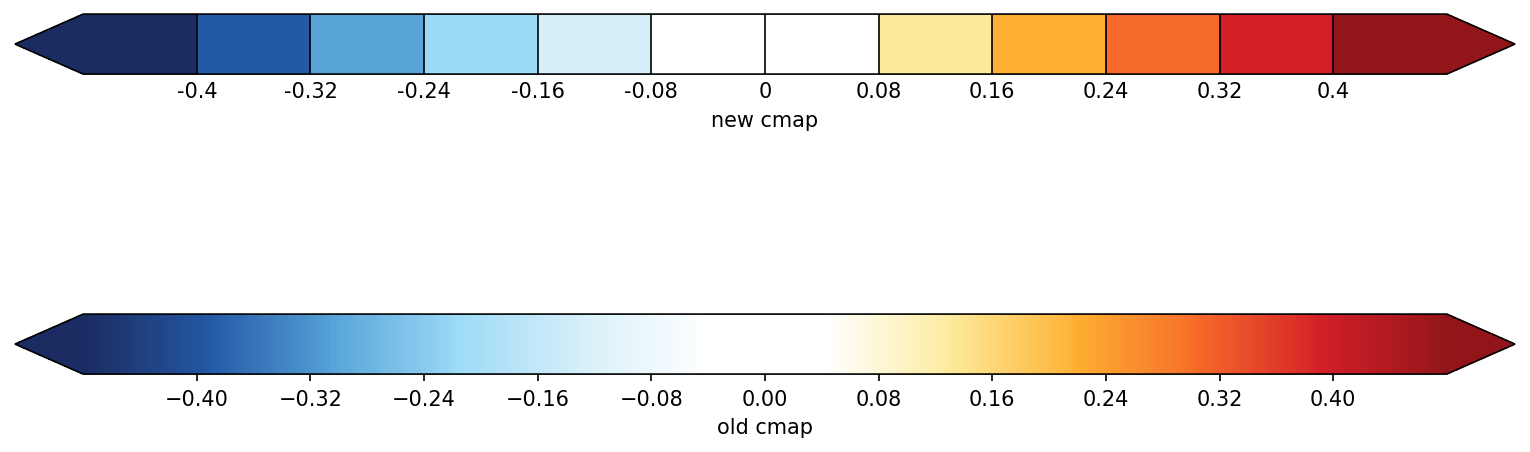

In [39]:
import numpy as np

import cmaps 

import matplotlib.pyplot as plt

import matplotlib as mpl   

from matplotlib.colors import ListedColormap 
#######################生成画板#####################################
fig=plt.figure(figsize=(10,8),dpi=150)

ax1=fig.add_axes([0,0,1,0.05])                                                 
ax2=fig.add_axes([0,0.25,1,0.05])  
#######################定义新的colormap#########################################
norm =mpl.colors.Normalize(vmin=-0.48, vmax=0.48)    #确定colormap的最大最小值

cmap=cmaps.BlueWhiteOrangeRed  #引用NCL的colormap

newcolors=cmap(np.linspace(0,1,12))#分片操作，生成0到1的12个数据间隔的数组   

newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

###########################################################################        
fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='BlueWhiteOrangeRed'),              
                 cax=ax1,                                                      
                 orientation='horizontal',    label='old cmap' ,
ticks=[-0.4,-0.32,-0.24,-0.16,-0.08,0,0.08,0.16,0.24,0.32,0.4]     ,                                                    
                 extend='both')                 

fc2=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=newcmap),                                            
                  cax=ax2,         format='%.2g'    ,                                             
                  orientation='horizontal',     label='new cmap' ,
ticks=[-0.4,-0.32,-0.24,-0.16,-0.08,0,0.08,0.16,0.24,0.32,0.4]     ,                                     
                  extend='both')  
fc2.ax.tick_params(which='major',direction='in',length=29)

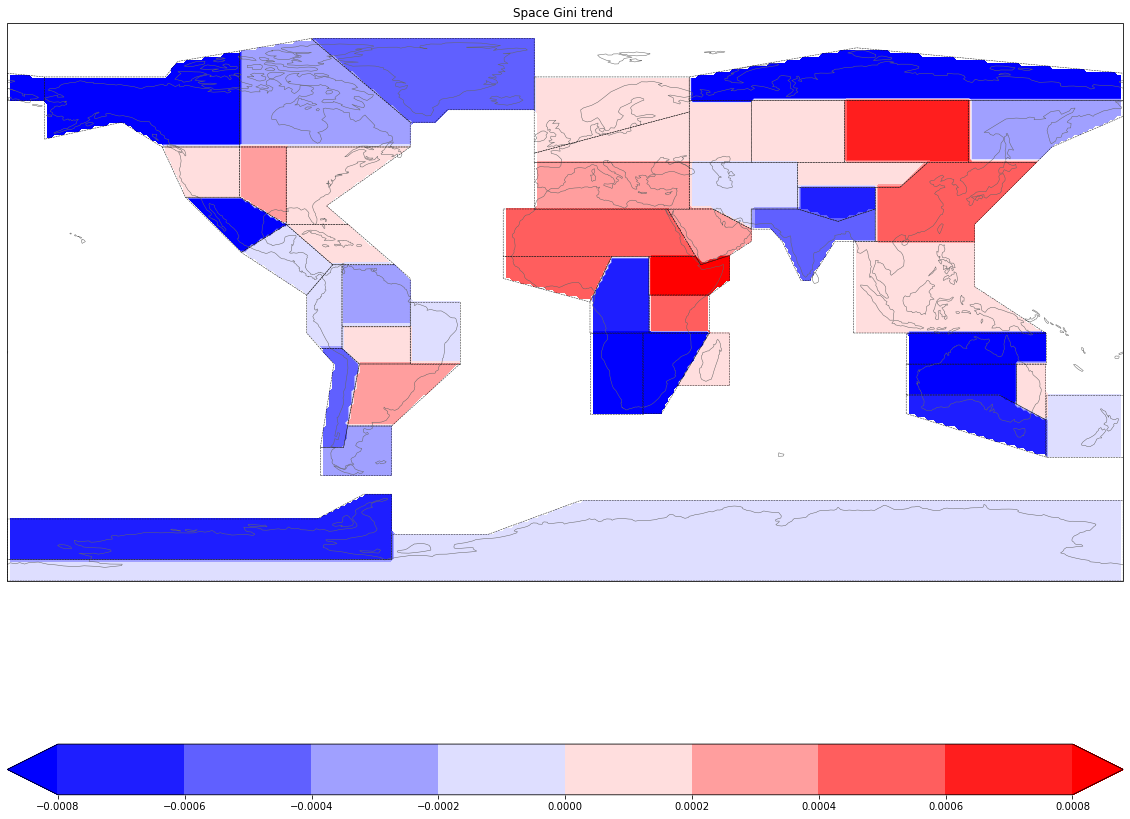

In [47]:
temp = np.full([len(pre_50_55.latitude),len(pre_50_55.longitude)],np.nan)
for region_ind in range(0,46):
    temp[mask==region_ind] = trend_gini_space[0,region_ind]
TGI_grid = xr.DataArray(temp,coords=[pre_50_55.latitude, pre_50_55.longitude],dims=['lat','lon'])

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
# ax.coastlines('110m')
import palettable
#levels=np.linspace(-0.001,0.001,5)

#cmap = palettable.cartocolors.diverging.Geyser_7.mpl_colormap
#cmap = palettable.cartocolors.diverging.Fall_7.mpl_colormap
cmap = 'bwr'
levels=np.arange(-0.0008,0.0009,0.0002)
x = pre_50_55.longitude
y = pre_50_55.latitude
z = TGI_grid#pr.prate.mean('time')


cycle_plot, cycle_lon = add_cyclic_point(z, coord=x)
cycle_LON, cycle_LAT = np.meshgrid(cycle_lon, y)

cf = ax.contourf(cycle_LON, cycle_LAT, cycle_plot, transform=ccrs.PlateCarree(),
                 cmap=cmap,
                 extend='both',levels=levels)
ax.set_title('Space Gini trend ')
cb=fig.colorbar(cf, orientation='horizontal')
#cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.rcParams['svg.fonttype'] = 'none'
ar6_land=regionmask.defined_regions.ar6.land
line_kws  = dict(
    lw=0.5,linestyle='--')
ax = ar6_land.plot(ax=ax,label="abbrev", line_kws=line_kws,add_label=False,add_coastlines=True) 
fig.savefig('trend Space Gini all.svg')

In [45]:
for i in range(0,46):
    if trend_gini_space[1,i]<0.001:
        print('极为显著区域：'+str(regionmask.defined_regions.ar6.land.regions[i]))
    elif trend_gini_space[1,i]>0.001 and trend_gini_space[1,i]<0.01:
        print('非常显著区域：'+str(regionmask.defined_regions.ar6.land.regions[i]))
    elif trend_gini_space[1,i]>0.01 and trend_gini_space[1,i]<0.05:
        print('显著区域：'+str(regionmask.defined_regions.ar6.land.regions[i]))

显著区域：<regionmask._OneRegion: Greenland/Iceland (GIC / 0)>
极为显著区域：<regionmask._OneRegion: N.W.North-America (NWN / 1)>
显著区域：<regionmask._OneRegion: N.Central-America (NCA / 6)>
非常显著区域：<regionmask._OneRegion: N.W.South-America (NWS / 9)>
显著区域：<regionmask._OneRegion: S.W.South-America (SWS / 13)>
极为显著区域：<regionmask._OneRegion: Sahara (SAH / 20)>
非常显著区域：<regionmask._OneRegion: Western-Africa (WAF / 21)>
极为显著区域：<regionmask._OneRegion: Central-Africa (CAF / 22)>
极为显著区域：<regionmask._OneRegion: N.Eastern-Africa (NEAF / 23)>
显著区域：<regionmask._OneRegion: S.Eastern-Africa (SEAF / 24)>
非常显著区域：<regionmask._OneRegion: W.Southern-Africa (WSAF / 25)>
极为显著区域：<regionmask._OneRegion: E.Southern-Africa (ESAF / 26)>
非常显著区域：<regionmask._OneRegion: Russian-Arctic (RAR / 28)>
非常显著区域：<regionmask._OneRegion: E.Siberia (ESB / 30)>
显著区域：<regionmask._OneRegion: Tibetan-Plateau (TIB / 34)>
非常显著区域：<regionmask._OneRegion: E.Asia (EAS / 35)>
极为显著区域：<regionmask._OneRegion: Arabian-Peninsula (ARP / 36)>
显著区域：<regionmask

In [49]:
gini_space_mean=np.nanmean(gini_space[:,-20:],axis=1)

In [58]:
np.nanmin(gini_space_mean)

0.10494985058427755

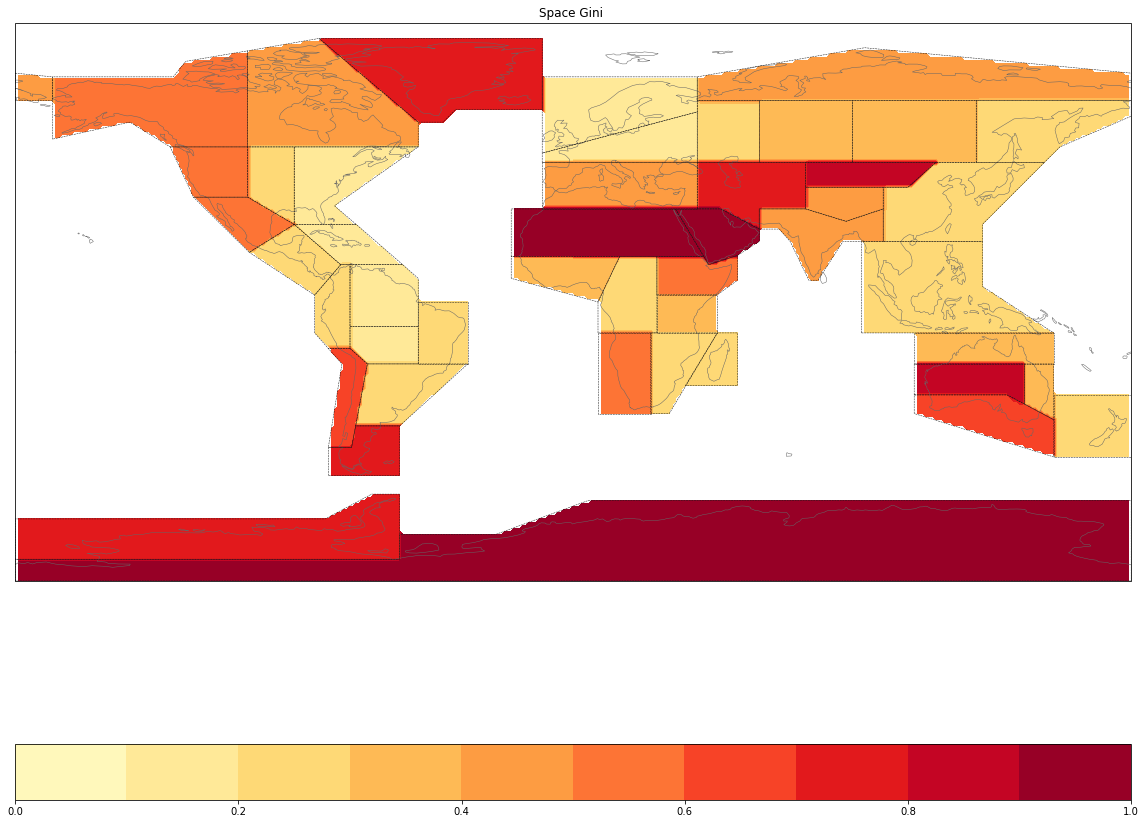

In [283]:
temp = np.full([len(pre_50_55.latitude),len(pre_50_55.longitude)],np.nan)
for region_ind in range(0,46):
    temp[mask==region_ind] = gini_space_mean[region_ind]
TGI_grid = xr.DataArray(temp,coords=[pre_50_55.latitude, pre_50_55.longitude],dims=['lat','lon'])

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
# ax.coastlines('110m')
import palettable
#levels=np.linspace(-0.001,0.001,5)

#cmap = palettable.cartocolors.diverging.Geyser_7.mpl_colormap
#cmap = palettable.cartocolors.diverging.Fall_7.mpl_colormap
cmap = 'YlOrRd'
levels=np.arange(0,1.1,0.1)
x = pre_50_55.longitude
y = pre_50_55.latitude
z = TGI_grid#pr.prate.mean('time')


cycle_plot, cycle_lon = add_cyclic_point(z, coord=x)
cycle_LON, cycle_LAT = np.meshgrid(cycle_lon, y)

cf = ax.contourf(cycle_LON, cycle_LAT, cycle_plot, transform=ccrs.PlateCarree(),
                 cmap=cmap,
                 levels=levels)
ax.set_title('Space Gini ')
cb=fig.colorbar(cf, orientation='horizontal')
#cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.rcParams['svg.fonttype'] = 'none'
ar6_land=regionmask.defined_regions.ar6.land
line_kws  = dict(
    lw=0.5,linestyle='--')
ax = ar6_land.plot(ax=ax,label="abbrev", line_kws=line_kws,add_label=False,add_coastlines=True) 
fig.savefig(' Space Gini all.svg')

In [66]:
np.save('trend_gini_space',trend_gini_space)

In [75]:
trend_gini_space.shape

(2, 46)

In [70]:
np.where(gini_space_mean==np.nanmax(gini_space_mean))

(array([20]),)

In [77]:
short_names=regionmask.defined_regions.ar6.land.abbrevs 

In [108]:
test=np.zeros((44,3))
test[:,0]=gini_space_mean[:-2]
test[:,1]=trend_gini_space[0,:-2]
test[:,2]=np.arange(0,44)
indices = np.argsort(-test[:, 1])
test_sorted = test[indices]

In [130]:
short_names[25]

'WSAF'

In [151]:
np.nanmean(pre_year_region_mean)

879.378709144314

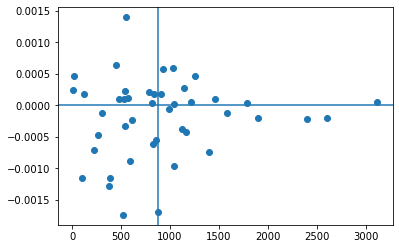

In [153]:
plt.scatter(pre_year_region_mean[:-2],trend_gini_space[0,:-2])plt.sav
plt.axvline(x=879)
plt.axhline(y=0)

In [236]:
humid_pre=[]
humid_gini_trend=[]
arid_pre=[]
arid_gini_trend=[]
for i in range(0,44):
   # if trend_gini_space[1,i]<0.05:
        if pre_year_region_mean[i]>1000:
            humid_pre.append(pre_year_region_mean[i])
            humid_gini_trend.append(trend_gini_space[0,i])
        if pre_year_region_mean[i]<250:
            arid_pre.append(pre_year_region_mean[i])
            arid_gini_trend.append(trend_gini_space[0,i])

In [263]:
pwd

'/home/user/降雨/Gini系数/Figure/v_4/fig.1'

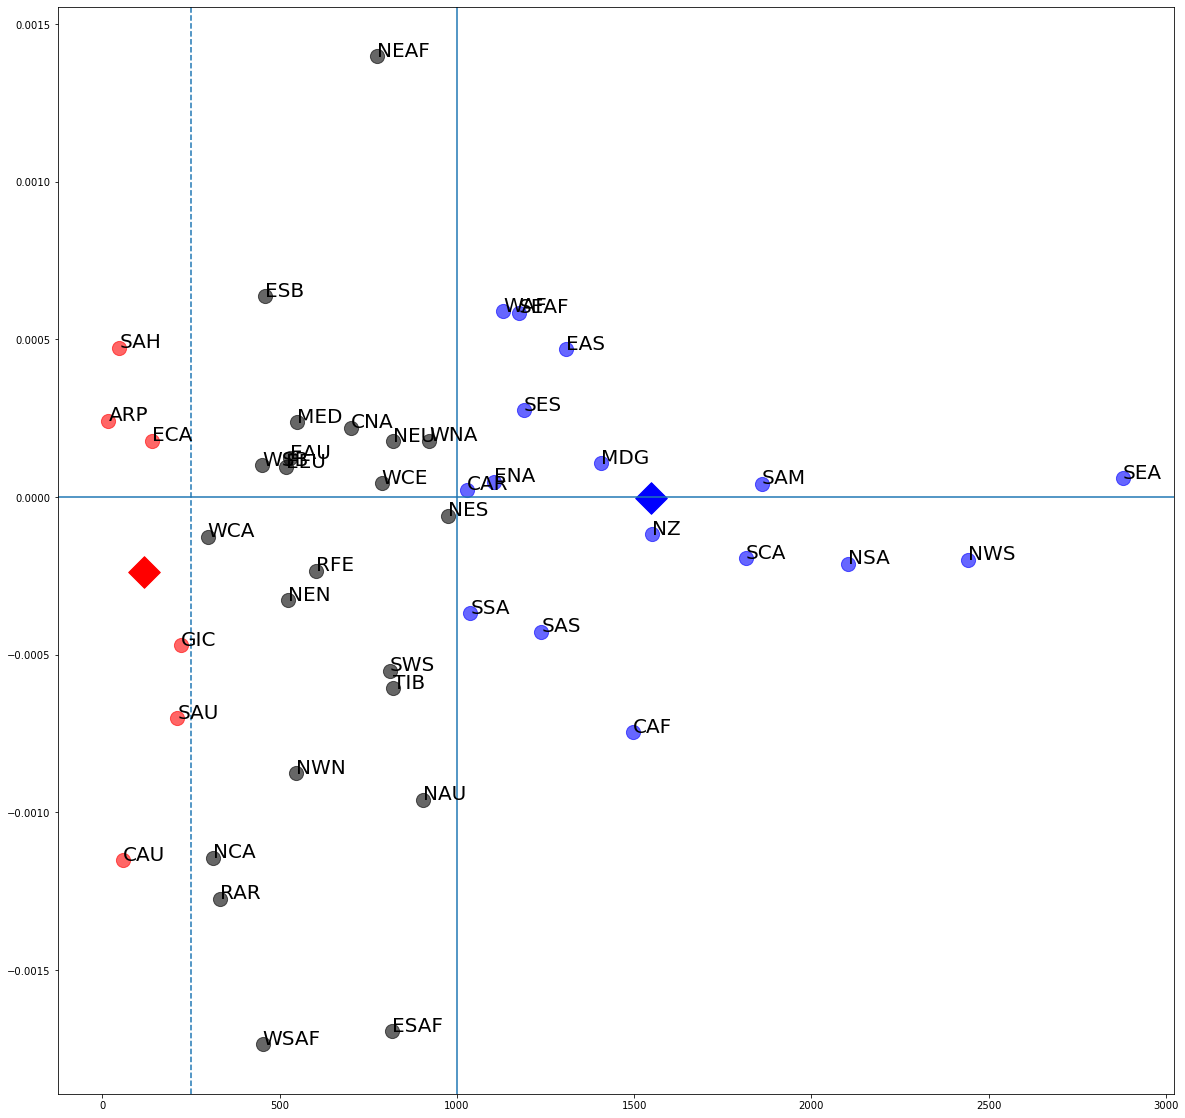

In [264]:
plt.figure(figsize=(20,20))
plt.axvline(x=1000)
plt.axhline(y=0)
plt.axvline(x=250,ls='--')
for i in range(0,44):
    #if trend_gini_space[1,i]<0.05:
        if pre_year_region_mean[i]>=1000:
            plt.scatter(pre_year_region_mean[i],trend_gini_space[0,i],s=200,alpha=0.6,color='blue')
            plt.text(pre_year_region_mean[i],trend_gini_space[0,i],short_names[i],fontsize=20)
        if pre_year_region_mean[i]<250:
            plt.scatter(pre_year_region_mean[i],trend_gini_space[0,i],s=200,alpha=0.6,color='red')
            plt.text(pre_year_region_mean[i],trend_gini_space[0,i],short_names[i],fontsize=20)
        elif pre_year_region_mean[i]>250 and pre_year_region_mean[i]<1000:
            plt.scatter(pre_year_region_mean[i],trend_gini_space[0,i],s=200,alpha=0.6,color='black')
            plt.text(pre_year_region_mean[i],trend_gini_space[0,i],short_names[i],fontsize=20)
            
plt.scatter(np.nanmean(humid_pre),np.nanmean(humid_gini_trend),color='blue',marker='D',s=500)
plt.scatter(np.nanmean(arid_pre),np.nanmean(arid_gini_trend),color='red',marker='D',s=500)
plt.savefig('ex1.svg')

In [238]:
len(humid_pre)

16

In [256]:
gini([1,1,1,1,10])

0.5142857142857143

In [258]:
gini([0.5,0.5,0.5,0.5,6])

0.55

In [187]:
np.nanmax(pre_trend_grid_region)

60.14796096552128

In [179]:
pre_year_grid_region=np.zeros((46,70,181,360))
for region in range(0,46):
    pre_year_grid_region[region,:]=pre_year_end[:,:,:]*mask_46[region,:]


In [241]:
pre_year_grid_region_mean=np.nanmean(pre_year_grid_region[:,0:20,:],axis=1)

In [252]:
pre_year_end_trend=np.zeros((2,181,360))
for lat in range(0,181):
    for lon in range(0,360):
        y1=pre_year_end[:,lat,lon]
        x1=np.arange(0,70)
        x1=sm.add_constant(x1)
        model1 = sm.OLS(y1,x1)
        res1 = model1.fit()
        pre_year_end_trend[0,lat,lon]=res1.params[1]
        pre_year_end_trend[1,lat,lon]=res1.pvalues[1]
pre_trend_grid_region=np.zeros((46,181,360))
for region in range(0,46):
    pre_trend_grid_region[region,:]=pre_year_end_trend[0,:,:]*mask_46[region,:]


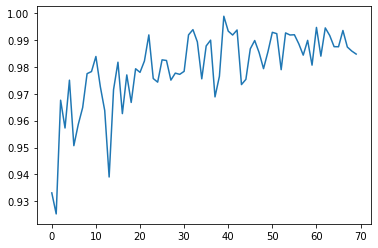

In [248]:
plt.plot(gini_space[20,:])

In [266]:
cd ./si

/home/user/降雨/Gini系数/Figure/v_4/fig.1/si


In [277]:
path

'43NZ.jpg'

<Figure size 432x360 with 0 Axes>

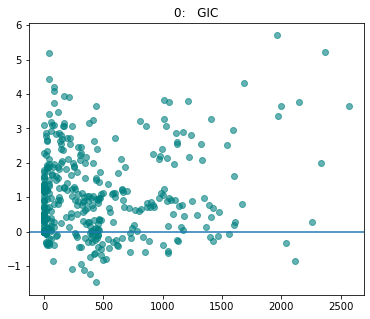

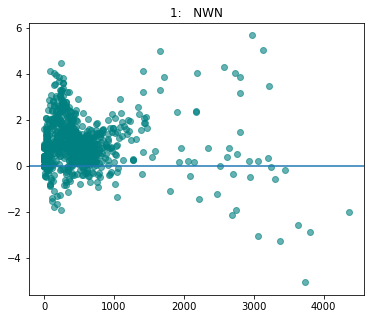

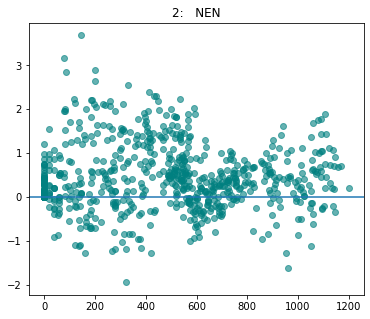

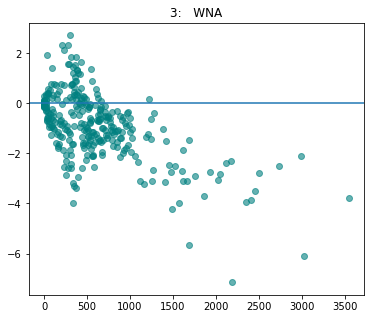

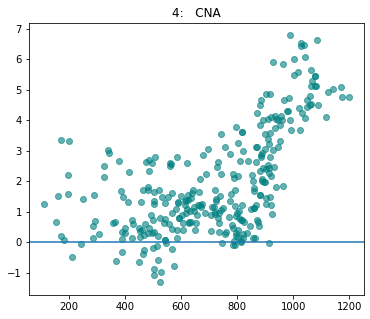

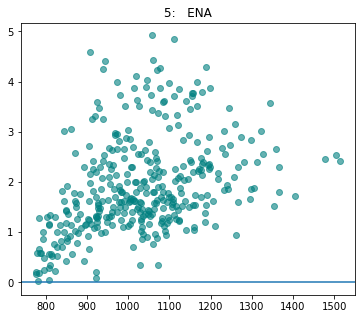

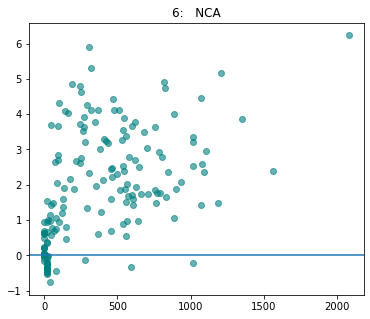

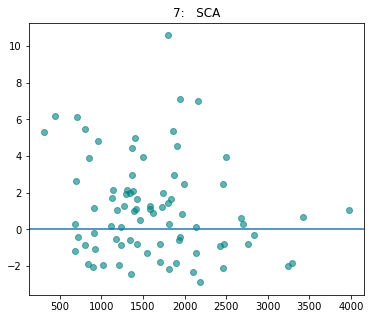

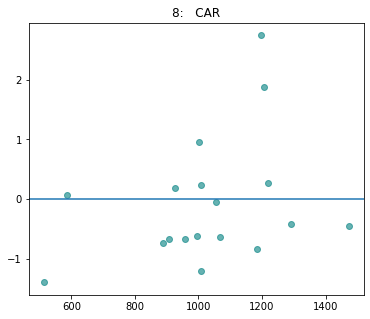

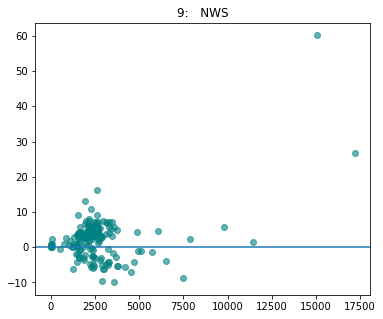

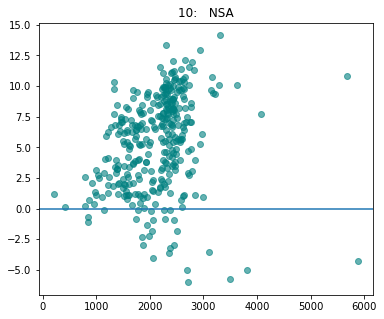

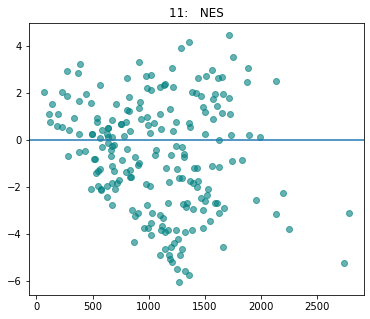

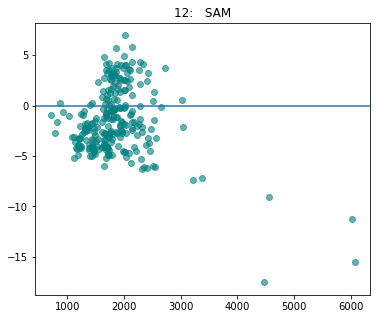

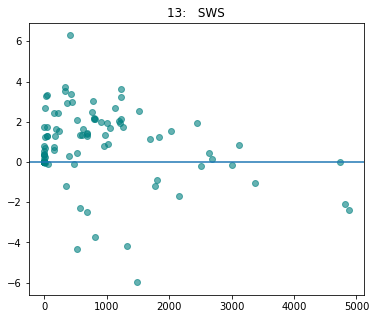

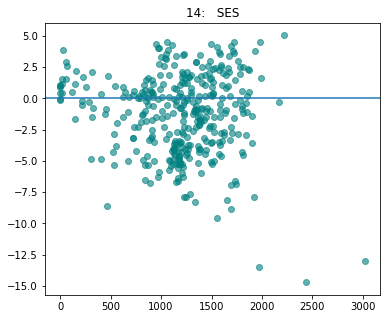

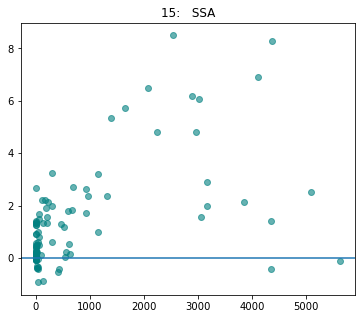

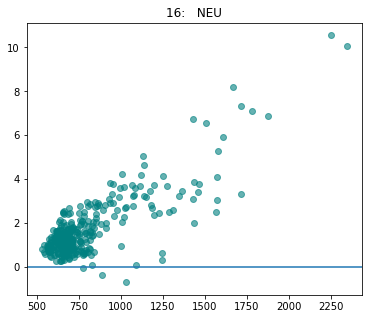

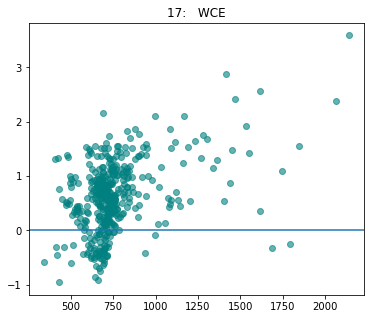

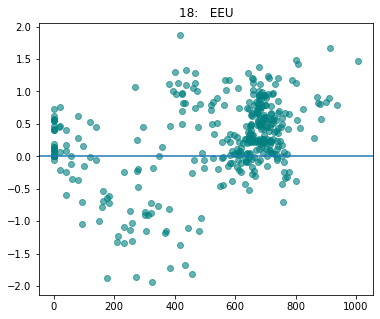

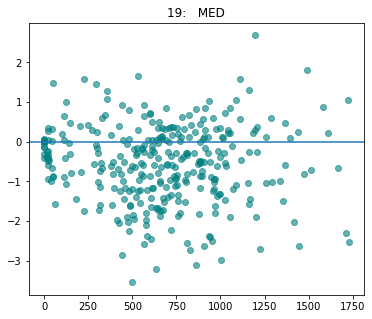

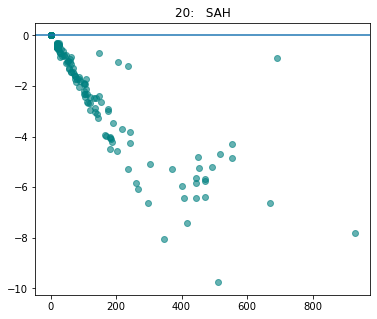

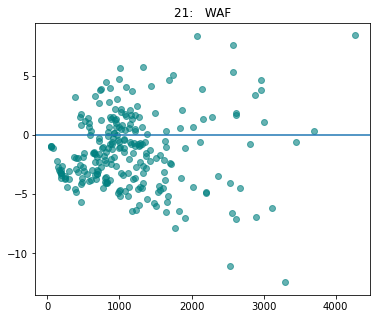

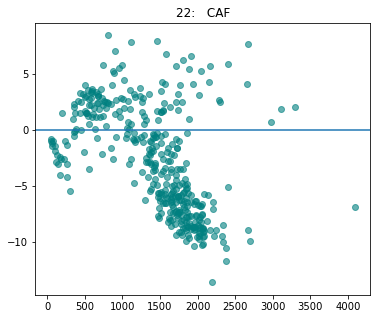

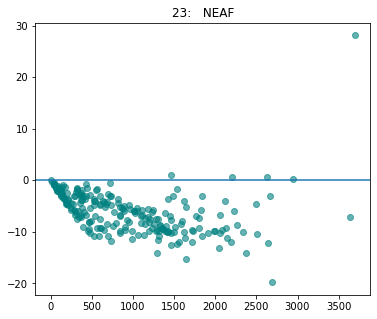

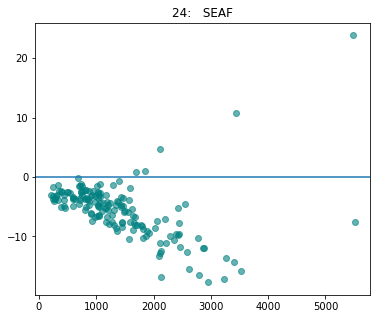

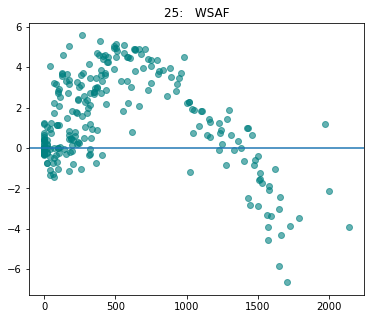

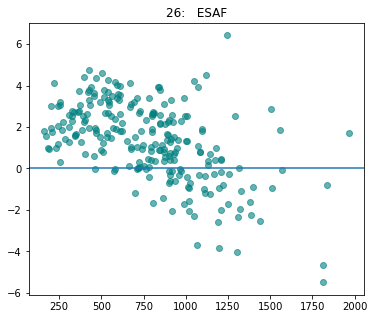

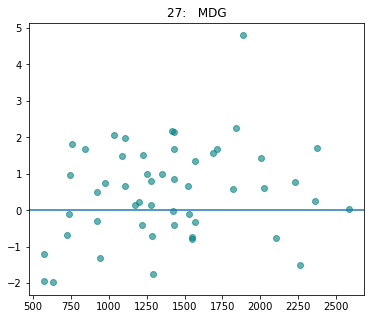

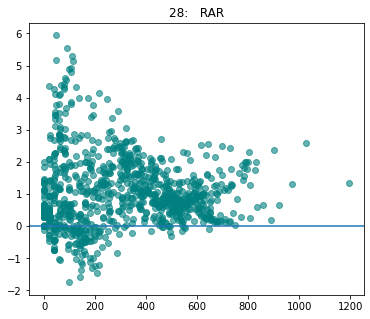

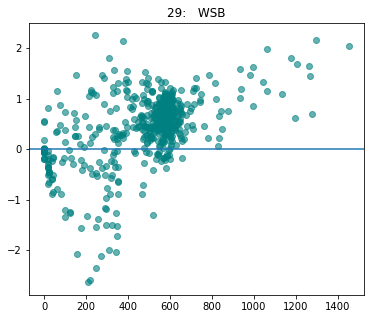

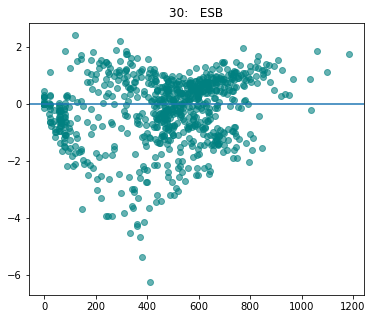

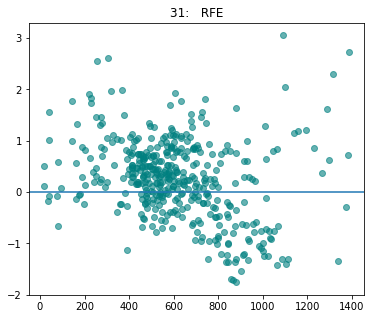

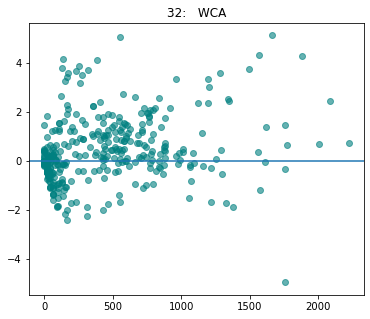

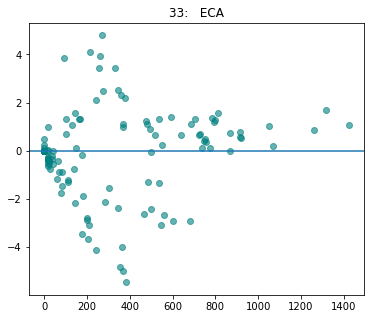

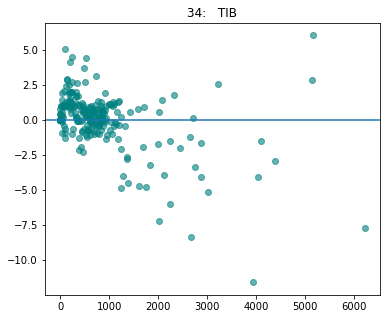

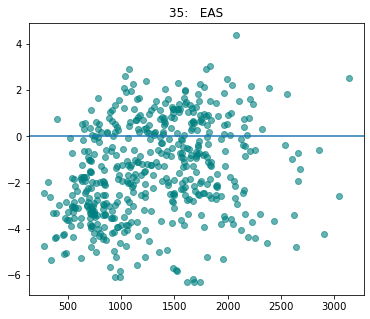

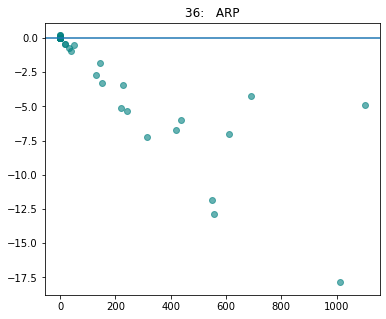

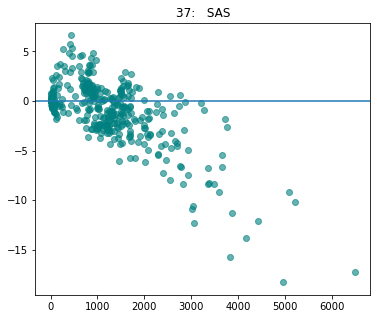

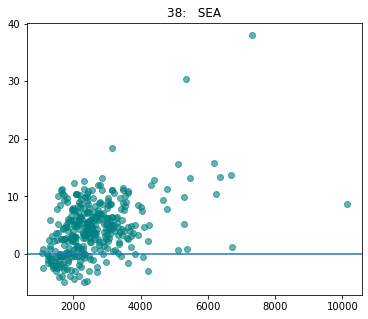

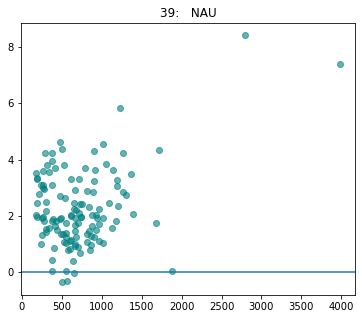

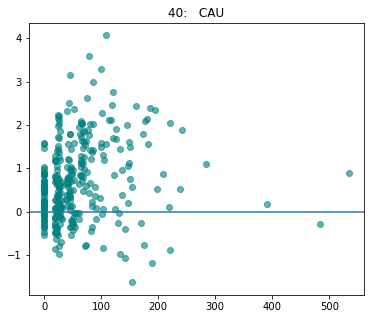

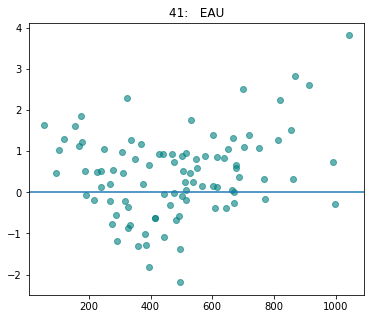

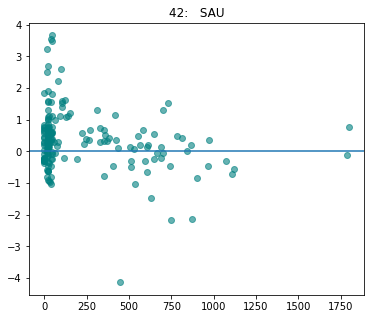

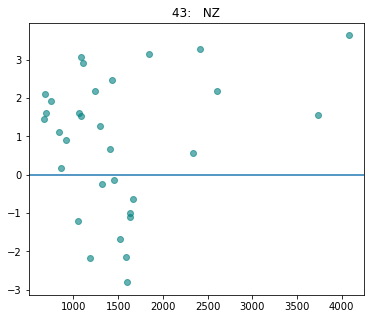

In [278]:
plt.figure(figsize=(6,5))

for i in range(0,44):
    plt.figure(figsize=(6,5))
    #plt.axvline(x=np.nanmean(pre_year_grid_region_mean[i,:]))
    plt.axhline(y=0)
    plt.scatter(pre_year_grid_region_mean[i,:],pre_trend_grid_region[i,:],alpha=0.6,color='#008080')
    plt.title(str(i)+':   '+short_names[i])
    path=str(i)+short_names[i]+'.svg'
    plt.savefig(path)
    plt.show()


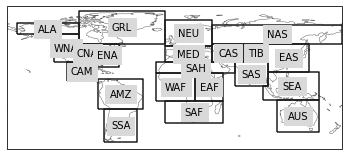

In [279]:
regionmask.defined_regions.giorgi.plot(label='abbrev')

In [281]:
regionmask.defined_regions.giorgi.source

'Giorgi and Franciso, 2000 (http://link.springer.com/article/10.1007/PL00013733)'